# EXAMEN SERIES TEMPORALES

## Aitor Larrinoa Rementería
### Máster en Data Science
### Curso 2021-2022


# 02.2_Examen_Modelos_horario

## LIBRERÍAS

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sktime.transformations.series.boxcox import LogTransformer

In [2]:
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet
from sktime.utils.plotting import plot_correlations

In [3]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import r2_score

## LECTURA DE LOS DATOS

Cargamos los datos modificados en el notebook *01_Examen_EDA*

In [4]:
table_horaria = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_horarios.parquet')
datos_horarios = table_horaria.to_pandas()

### Análisis descriptivo de los datos

Veamos rápidamente cuáles son los valores descriptivos más imporantes de nuestra serie temporal

In [5]:
np.round(datos_horarios.describe(),0)

,D
count,56280.0
mean,31536.0
std,6438.0
min,5719.0
25%,26871.0
50%,30323.0
75%,34129.0
max,62787.0


#### ¿TIENEN LOS DATOS HORARIOS COMPONENTE ESTACIONAL HORARIA?

Al igual que en el notebook *02_Examen_Modelos_diario*, veremos si existe estacionalidad horaria en los datos diarios. Lo haremos creando un nuevo data frame y agrupando todos los datos por horas, para así después poder calcular los boxplot de los datos.

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7750/98139930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_horarios_new["hora"] = datos_horarios_new.index.hour + 1


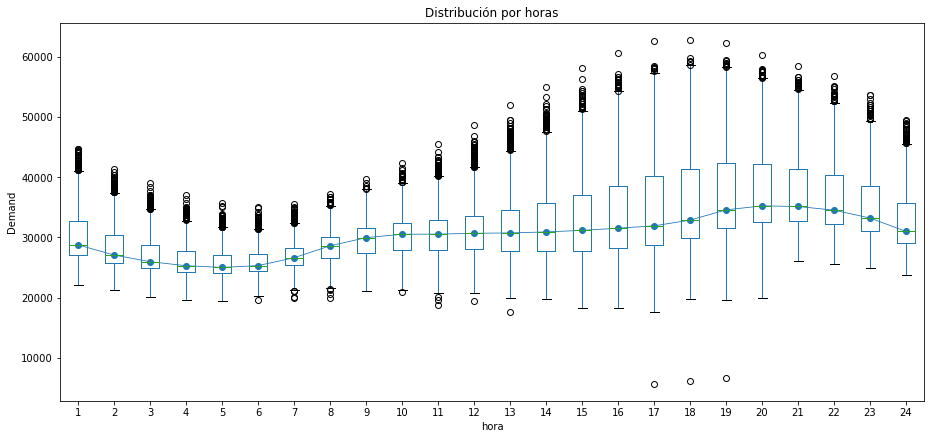

In [6]:
fig, ax = plt.subplots(figsize = (15, 7))
datos_horarios_new = datos_horarios[:]
datos_horarios_new["hora"] = datos_horarios_new.index.hour + 1
datos_horarios_new.boxplot(column="D", by="hora", ax=ax)
datos_horarios_new.groupby("hora")["D"].median().plot(style="-o", linewidth=0.8, ax=ax)
ax.set_ylabel("Demand")
ax.set_title("Distribución por horas")
fig.suptitle("");
plt.savefig("Images/Tendencia_horaria_datos_horarios.png", dpi=300, bbox_inches='tight')

Podemos observar como claramente aparece una componente estacional horaria en los datos. A la madrugada hay menos demanda que a las horas de la tarde por ejemplo.

## DESCOMPOSICIÓN STL

STL es un método para la descomposición de series temporales. Sus siglas corresponden a *Seasonal and Trend decomposition using Loess*.

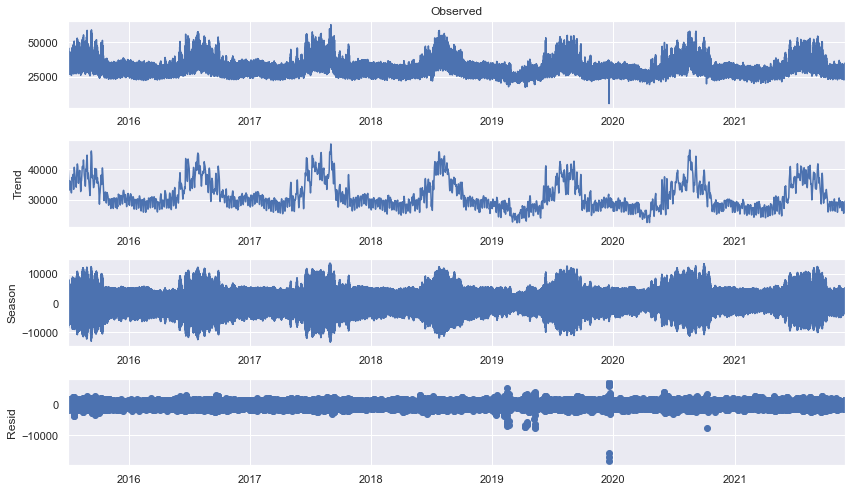

In [7]:
sns.set(rc={'figure.figsize':(12, 7)})

stl = STL(datos_horarios)
res = stl.fit()
fig = res.plot()

Podemos observar que los datos no tienen tendencia. Visualicemos ahora todos los datos horarios.

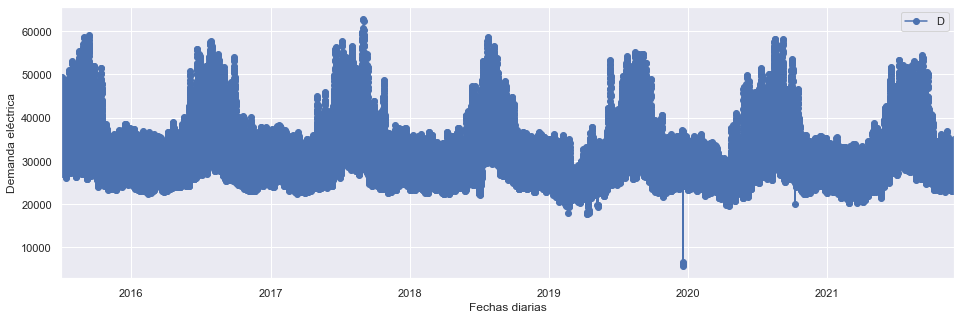

In [8]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

Debido a que nuestro objetivo es predecir en el mes de diciembre, tomaremos los datos desde octubre del 2021. Dado que no nos encontramos en fechas de invierno, y vemos claramente que el verano tiene un gran impacto en la demanda, eliminamos los datos que contengan meses de verano y comenzamos a analizar la serie desde octubre.

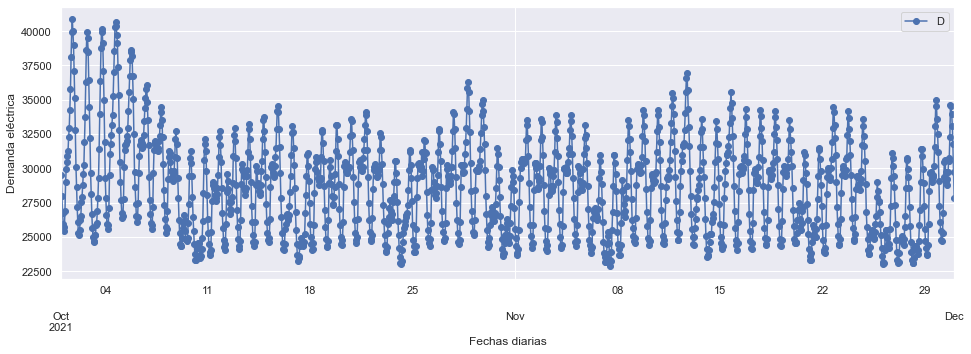

In [9]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios["2021-10":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

In [10]:
datos_horarios_d_2021_10 = datos_horarios["2021-10":].to_period("H")

Vamos a separar los datos en training y testing. Para el conjunto de testing vamos a tomar dos días, equivalentemente 48 horas y, por ende, debemos tomar 48 datos.

Las dimensiones del dataset de training y testing son: 1225 y 240


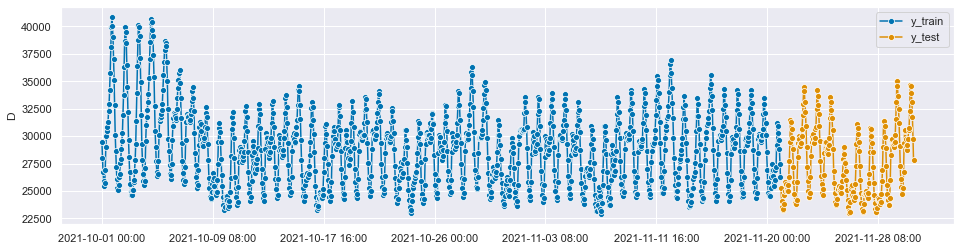

In [11]:
y_train_horario, y_test_horario = temporal_train_test_split(y = datos_horarios_d_2021_10["D"].astype('float64'), test_size=240)
plot_series(y_train_horario, y_test_horario, labels=["y_train", "y_test"])
print("Las dimensiones del dataset de training y testing son:" ,y_train_horario.shape[0], "y", y_test_horario.shape[0])

In [12]:
y_test_horario

2021-11-21 01:00    25239.0
2021-11-21 02:00    24075.0
2021-11-21 03:00    23579.0
2021-11-21 04:00    23286.0
2021-11-21 05:00    23324.0
                     ...   
2021-11-30 20:00    33941.0
2021-11-30 21:00    33098.0
2021-11-30 22:00    31768.0
2021-11-30 23:00    29751.0
2021-12-01 00:00    27799.0
Freq: H, Name: D, Length: 240, dtype: float64

### MODELO BASE

El modelo base del que haremos uso será el método ingenuo (Naive). Este método es utilizado en series temporales con componente estacional. Sencillamente, si por ejemplo queremos predecir datos trimestrales, la predicción del trimestre que queramos predecir tomará el valor del trimestre anterior. 

In [13]:
fh = np.arange(1, 241)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

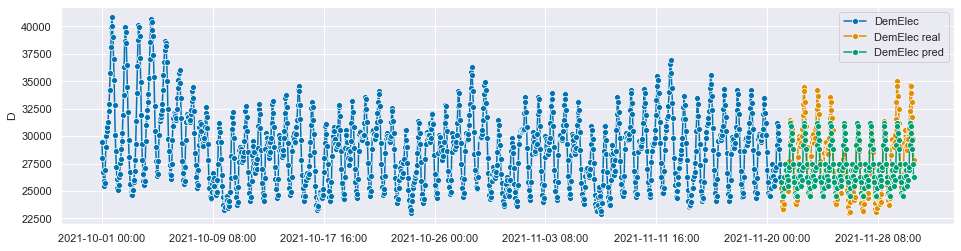

In [14]:
Met_Naive = NaiveForecaster(strategy="last", sp=24)

Met_Naive.fit(y_train_horario)

# step 5: querying predictions
pred_Naive = Met_Naive.predict(fh)

plot_series(y_train_horario, y_test_horario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])

Vamos a ampliar la predicción para verla mejor.

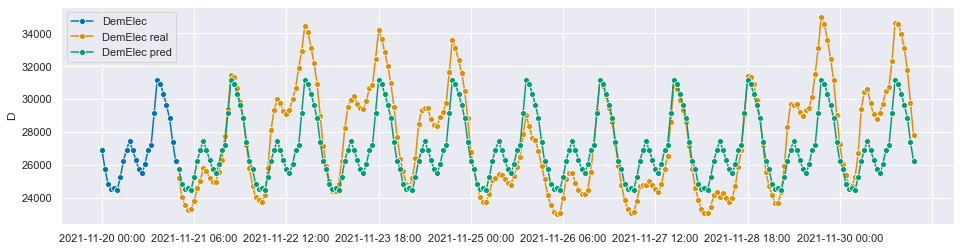

In [15]:
plot_series(y_train_horario[1200:], y_test_horario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/Naive_datos_horarios.png", dpi=300, bbox_inches='tight')

La predicción, a simple vista, vemos que falla mucho al principio. Sin embargo, a medida que avanza el tiempo acierta cada vez más. Para tener una visión estadística de la predicción, hallaremos el error cuadrático medio.

In [16]:
MAPE_NAIVE = mean_absolute_percentage_error(y_test_horario, pred_Naive)
MAPE_NAIVE

0.059968875136757346

In [17]:
rmse_NAIVE = MeanSquaredError(square_root=True)
rmse_NAIVE =rmse_NAIVE(y_test_horario, pred_Naive)
rmse_NAIVE

2032.2744237266122

In [18]:
r2_NAIVE = r2_score(y_test_horario, pred_Naive)
r2_NAIVE

0.5740136285798553

Este será nuestro modelo base y, a partir de aquí, todos los modelos que vayamos considerando deberán mejorar los resultados que acabamos de obtener.

## MODELO ETS

In [19]:
ETS_horario = AutoETS(auto=True, sp=24, n_jobs=-1) 

In [20]:
ETS_horario.fit(y_train_horario)
print(ETS_horario.summary())

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                 1225
Model:                      ETS(MAdM)   Log Likelihood               -9025.510
Date:                Fri, 21 Jan 2022   AIC                          18113.021
Time:                        14:35:49   BIC                          18271.452
Sample:                    10-01-2021   HQIC                         18172.640
                         - 11-21-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9709      0.047     20.666      0.000       0.879       1.063
smoothing_trend         0.7491      0.090      8.316      0.000       0.573       0.926
smoothing_season

In [21]:
ETS_horario_pred = ETS_horario.predict(fh)
print(ETS_horario_pred)

2021-11-21 01:00    25381.072995
2021-11-21 02:00    24803.168040
2021-11-21 03:00    24477.550117
2021-11-21 04:00    24397.841743
2021-11-21 05:00    24709.283978
                        ...     
2021-11-30 20:00    33801.234710
2021-11-30 21:00    32918.244160
2021-11-30 22:00    31569.624605
2021-11-30 23:00    29661.143248
2021-12-01 00:00    27870.651069
Freq: H, Length: 240, dtype: float64


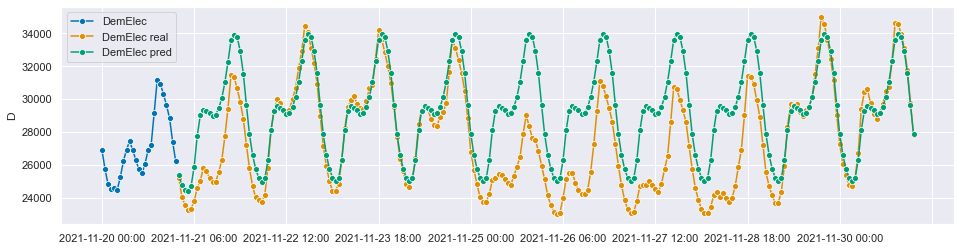

In [22]:
plot_series(y_train_horario[1200:], y_test_horario, ETS_horario_pred, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/ETS_datos_horarios.png", dpi=300, bbox_inches='tight')

#### RESIDUOS

In [23]:
residuals_ETS_df = pd.DataFrame(ETS_horario_pred, columns=["D"])
residuals_ETS_df["real_D"] = y_test_horario
residuals_ETS_df["residuals"] = residuals_ETS_df["real_D"]-residuals_ETS_df["D"]
residuals_ETS_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_ETS_df

,predicted_D,real_D,residuals
2021-11-21 01:00,25381.072995,25239.0,-142.072995
2021-11-21 02:00,24803.168040,24075.0,-728.168040
2021-11-21 03:00,24477.550117,23579.0,-898.550117
2021-11-21 04:00,24397.841743,23286.0,-1111.841743
2021-11-21 05:00,24709.283978,23324.0,-1385.283978
...,...,...,...
2021-11-30 20:00,33801.234710,33941.0,139.765290
2021-11-30 21:00,32918.244160,33098.0,179.755840
2021-11-30 22:00,31569.624605,31768.0,198.375395
2021-11-30 23:00,29661.143248,29751.0,89.856752


Veamos gráficamente estos residuos.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

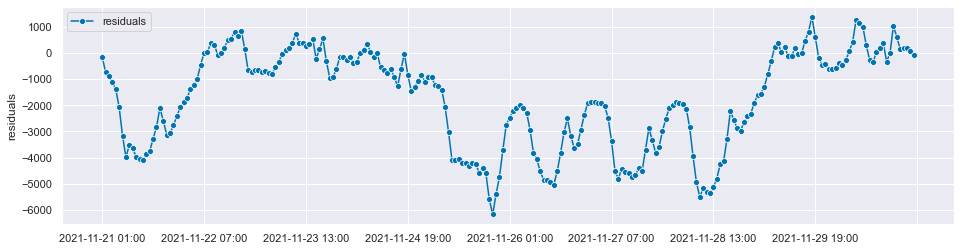

In [24]:
plot_series(residuals_ETS_df["residuals"], labels=["residuals"])

Podemos observar que el mayor de los residuos llega a superar el valor de 6000. Teniendo en cuenta que los datos horarios se sitúan, de media, entre los valores 25000 y 30000, podemos decir que el error máximo obtenido es un error alto. Veamos el valor de las métricas a continuación:

#### MÉTRICAS

Vemos que la predicción es realmente mala. Veamos cuales son los valores de las métricas de error.

In [25]:
MAPE_ETS = mean_absolute_percentage_error(y_test_horario, ETS_horario_pred)
MAPE_ETS

0.06847126618582625

In [26]:
rmse_ETS = MeanSquaredError(square_root=True)
rmse_ETS = rmse_ETS(y_test_horario, ETS_horario_pred)
rmse_ETS

2537.3927422155393

In [27]:
r2_ETS = r2_score(y_test_horario, ETS_horario_pred)
r2_ETS

0.3359414260994231

Vemos que las métricas son bastante peores que las obtenidas con el modelo base. Luego, no es un buen modelo.

## MODELO ARIMA

La serie que estamos analizando es estacionaria en media pero, no lo es en varianza. Luego, deberemos transformar la serie. La transformación la haremos haciendo uso de la función logaritmo.

In [28]:
transformer = LogTransformer()
log_DemElec_horario = transformer.fit_transform(datos_horarios_d_2021_10)
log_DemElec_horario.tail()

,D
2021-11-30 20:00,10.432379
2021-11-30 21:00,10.407228
2021-11-30 22:00,10.366215
2021-11-30 23:00,10.300618
2021-12-01 00:00,10.232755


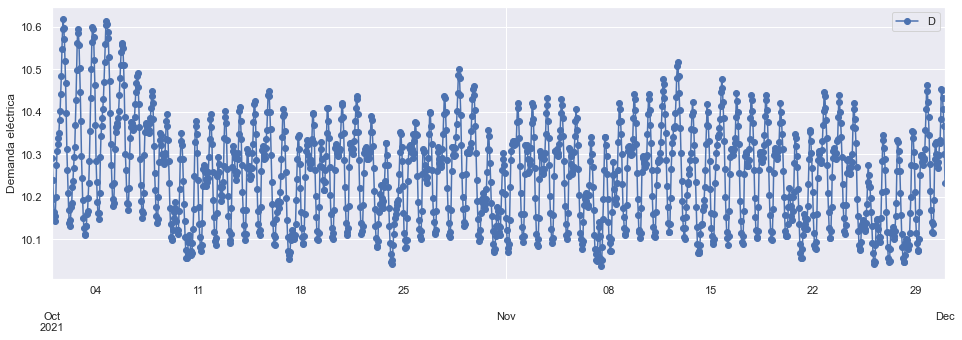

In [29]:
sns.set(rc = {"figure.figsize":(16,5)})
ax = log_DemElec_horario.plot(marker = 'o', linestyle='-')
ax.set_ylabel('Demanda eléctrica');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

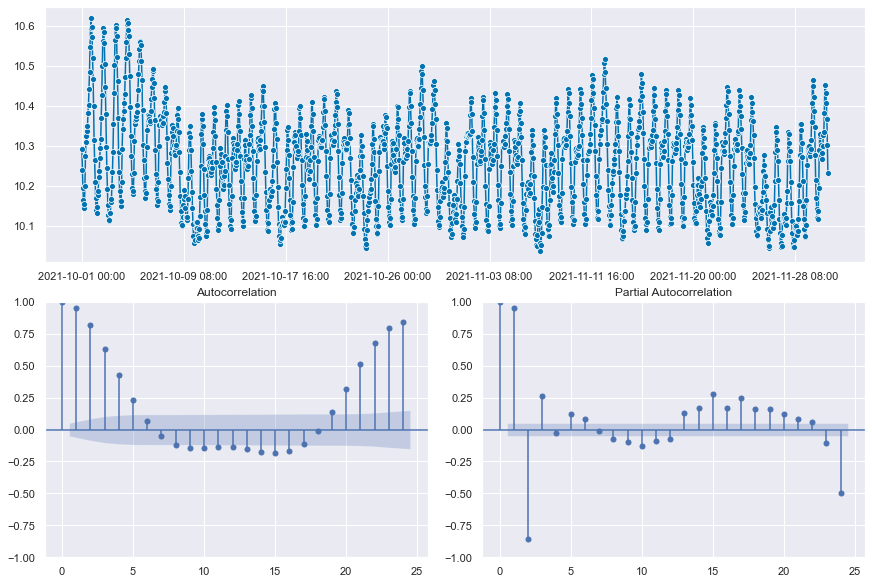

In [31]:
plot_correlations(log_DemElec_horario)

Separamos nuestra serie logarítmica en train y test con un test size de 10 días en periodicidad horaria.

In [32]:
log_y_train, log_y_test = temporal_train_test_split(y = log_DemElec_horario, test_size=240)

Calculamos el modelo ARIMA, lo entrenamos y mostramos el resultado.

In [33]:
ARIMA_horario = AutoARIMA(sp=24, suppress_warnings=True)

ARIMA_horario.fit(log_y_train)

AutoARIMA(sp=24, suppress_warnings=True)

In [34]:
print(ARIMA_horario.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 1225
Model:             SARIMAX(1, 1, 5)x(2, 0, [1, 2], 24)   Log Likelihood                3660.742
Date:                                 Fri, 21 Jan 2022   AIC                          -7299.483
Time:                                         14:46:46   BIC                          -7243.275
Sample:                                              0   HQIC                         -7278.331
                                                - 1225                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8407      0.038     22.112      0.000       0.766       0

Calculamos la predicción en nuestro horizonte de predicción.

In [35]:
y_pred_horario_ARIMA = ARIMA_horario.predict(fh)

Deberemos deshacer el logaritmo para obtener las predicciones reales. Esto es, aplicaremos la función exponencial a nuestras predicciones.

In [36]:
np.exp(y_pred_horario_ARIMA)

,D
2021-11-21 01:00,25324.659795
2021-11-21 02:00,24603.618604
2021-11-21 03:00,24227.374325
2021-11-21 04:00,24181.869951
2021-11-21 05:00,24261.456481
...,...
2021-11-30 20:00,27848.203068
2021-11-30 21:00,27253.906807
2021-11-30 22:00,26495.447192
2021-11-30 23:00,25371.492194


Veamos el rendimiento gráfico de nuestro modelo mediante la función plot_series() la cual nos permite graficar varias series temporales a la vez.

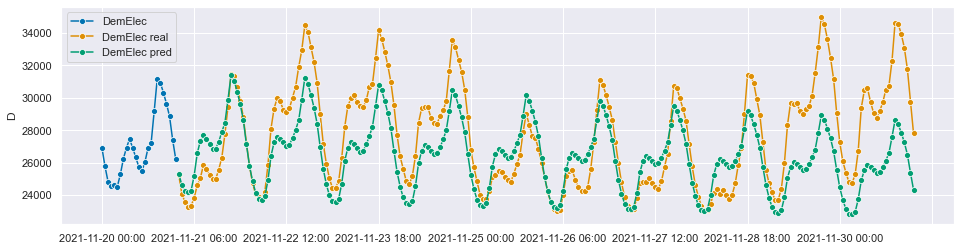

In [37]:
plot_series(y_train_horario[1200:], y_test_horario , np.exp(y_pred_horario_ARIMA), labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/ARIMA_datos_horarios.png", dpi=300, bbox_inches='tight')

#### RESIDUOS

En primer lugar, deberemos crear un data frame en el que poder tener dos columnas, una será la columna de datos reales y otra será la columna de datos predichos. Una vez tenemos el data frame, crearemos una nueva columna, la cual será la diferencia entre valor real y valor observado. Así tendremos un df con 3 columnas, valor predicho, valor real y residuo. 

In [38]:
residuals_ARIMA_df = np.exp(y_pred_horario_ARIMA)
residuals_ARIMA_df["real_D"] = y_test_horario
residuals_ARIMA_df["residuals"] = residuals_ARIMA_df["real_D"]-residuals_ARIMA_df["D"]
residuals_ARIMA_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_ARIMA_df

,predicted_D,real_D,residuals
2021-11-21 01:00,25324.659795,25239.0,-85.659795
2021-11-21 02:00,24603.618604,24075.0,-528.618604
2021-11-21 03:00,24227.374325,23579.0,-648.374325
2021-11-21 04:00,24181.869951,23286.0,-895.869951
2021-11-21 05:00,24261.456481,23324.0,-937.456481
...,...,...,...
2021-11-30 20:00,27848.203068,33941.0,6092.796932
2021-11-30 21:00,27253.906807,33098.0,5844.093193
2021-11-30 22:00,26495.447192,31768.0,5272.552808
2021-11-30 23:00,25371.492194,29751.0,4379.507806


Mostremos ahora una gráfica en la que veremos la evolución de los residuos.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

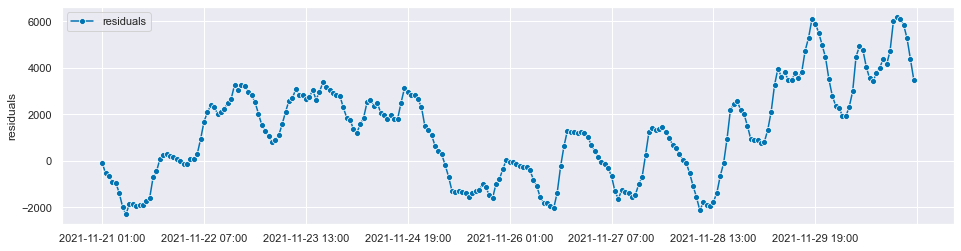

In [39]:
plot_series(residuals_ARIMA_df["residuals"], labels=["residuals"])

De momento no podemos sacar grandes conclusiones a partir del gráfico. Es por ello que procedemos a calcular los valores de las métricas.

#### MÉTRICAS

In [40]:
MAPE_ARIMA = mean_absolute_percentage_error(y_test_horario, y_pred_horario_ARIMA)
MAPE_ARIMA

1.9985076150091392

In [41]:
rmse_ARIMA = MeanSquaredError(square_root=True)
rmse_ARIMA = rmse_ARIMA(y_test_horario, y_pred_horario_ARIMA)
rmse_ARIMA

27755.568903384054

In [42]:
r2_ARIMA = r2_score(y_test_horario, y_pred_horario_ARIMA)
r2_ARIMA

-78.45683625601025

## MODELO PROPHET

Para poder hacer uso del modelo Prophet necesitaremos tener un data frame de dos columnas. La primera columna será la feha y se llamará *ds* y la segunda columna será la demanda, denotada por *y*. Este formato de df lo exige la propia librería Prophet.

In [43]:
y = datos_horarios["2021-10":].reset_index(drop=False)
y.columns = ["ds", "y"]
y.tail()

,ds,y
1460,2021-11-30 20:00:00,33941.0
1461,2021-11-30 21:00:00,33098.0
1462,2021-11-30 22:00:00,31768.0
1463,2021-11-30 23:00:00,29751.0
1464,2021-12-01 00:00:00,27799.0


Ahora separamos en train y test teniendo en cuenta que el conjunto de training antes calculado tiene 1225 datos.

In [44]:
train = y.iloc[:1225,:]
test = y.iloc[1225:,:]

Comprobemos que, efectivamente, tenemos 240 datos en el conjunto de test.

In [45]:
len(test)

240

Definamos y entrenemos el modelo Prophet.

In [46]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.6242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       3546.85   7.30575e-05       132.603   5.557e-07       0.001      151  LS failed, Hessian reset 
      99       3548.52   0.000752466       150.093       2.487      0.2487      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3556.75     0.0012255       151.595           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3564.16   0.000296256        90.949      0.4174      0.4174      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3565.5   0.000120839       77.0399      0.7523      0.7523      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3567.14    0.00438194     

In [47]:
future = m.make_future_dataframe(periods=len(test), freq="H")
forecast = m.predict(future)

71   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     500       3567.16   0.000110579       179.049   3.008e-07       0.001      737  LS failed, Hessian reset 
     572       3568.12   4.84691e-05       109.139   4.407e-07       0.001      871  LS failed, Hessian reset 
     599       3568.38   0.000535594       117.235      0.4108           1      908   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     633       3568.51   0.000159363       188.339   2.016e-06       0.001      982  LS failed, Hessian reset 
     699       3568.68   2.19802e-05       52.9769      0.4369      0.4369     1066   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     726       3568.81   9.87189e-05       179.603    6.79e-07       0.001     1150  LS failed, Hessian reset 
     754       3568.91   0.000125517       189.663   1.472e-06       0.001     1218  LS failed, Hess

Para poder graficar los resultados con la función plot_series, debemos modificar ligeramente nuestros datos, pues todas las series introducidas en la función plot_series deben tener el mismo tipo de índice.

In [48]:
forecast_new = forecast[:]
forecast_new.index = datos_horarios_d_2021_10.index
forecast_new = forecast_new[["yhat"]]

Mostremos gráficamente el rendimiento de nuestro modelo Prophet comparándolo con el conjunto de testing.

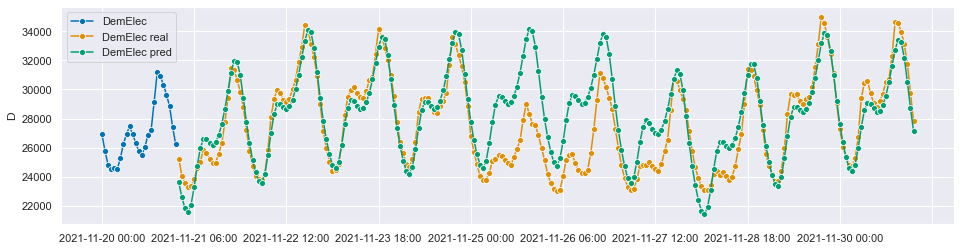

In [49]:
plot_series(y_train_horario[1200:], y_test_horario, forecast_new[1225:], labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/PROPHET_datos_horarios.png", dpi=300, bbox_inches='tight')

#### RESIDUOS

Al igual que con los anteriores modelos, 

In [50]:
forecast_new = forecast[:]

In [51]:
forecast_new.index = forecast["ds"]
residuals_PROPHET_df = forecast[["yhat"]][1225:]
residuals_PROPHET_df["real_D"] = np.array(y_test_horario)
residuals_PROPHET_df["residuals"] = residuals_PROPHET_df["real_D"]-residuals_PROPHET_df["yhat"]
residuals_PROPHET_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_PROPHET_df

,predicted_D,real_D,residuals
1225,23614.507765,25239.0,1624.492235
1226,22580.569309,24075.0,1494.430691
1227,21837.067163,23579.0,1741.932837
1228,21595.799068,23286.0,1690.200932
1229,22081.121215,23324.0,1242.878785
...,...,...,...
1460,33246.296688,33941.0,694.703312
1461,32174.847850,33098.0,923.152150
1462,30500.096926,31768.0,1267.903074
1463,28704.152278,29751.0,1046.847722


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

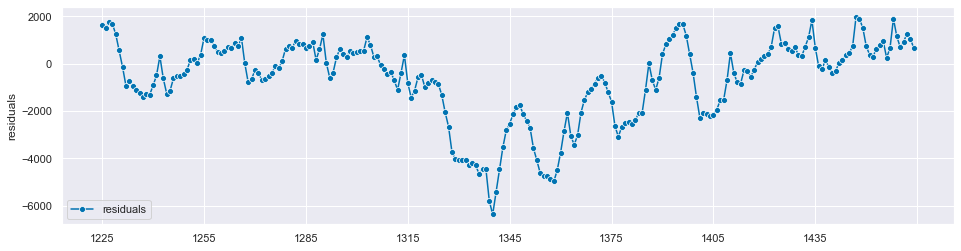

In [52]:
plot_series(residuals_PROPHET_df["residuals"], labels=["residuals"])

Aunque es cierto que el residuo máximo llega a alcanzar el valor de 6000, los demás residuos no son muy grandes y se sitúan cerca del 0. Luego, a simple vista, parece que este modelo mejora los anteriores. Veamos sus métricas. 

#### MÉTRICAS

In [53]:
r2_PROPHET = r2_score(list(test['y']), list(forecast.loc[1225:,'yhat']))
r2_PROPHET

0.6412157302041268

In [54]:
MAPE_PROPHET = mean_absolute_percentage_error(test["y"], forecast.loc[1225:,'yhat'])
MAPE_PROPHET

0.0487073604711172

In [55]:
rmse_PROPHET = MeanSquaredError(square_root=True)
rmse_PROPHET = rmse_PROPHET(test["y"], forecast.loc[1225:,'yhat'])
rmse_PROPHET

1865.0960232890861

## MODELO AMAZON DEEPAR

Tomamos el dataset creado para utilizar Prophet y le modificamos el nombre de las columnas, pues la librería gluonts trabaja con una columna "date" y una columna "y".

In [56]:
y.columns=["date", "y"]

Ahora debemos separar en train y test. Los conjuntos de training y testing los llamaremos train_ds y test_ds respectivamente. El conjunto de training debe contener 670 datos y el conjunto de testing debe contener 30 datos.

In [57]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("2021-10-01", freq="H")
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[:1225,'y'], 'start': start}], freq='H')
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': y['y'], 'start': start}],freq='H')

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7750/968115320.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2021-10-01", freq="H")


Visualicemos ahora los conjuntos de train y test obtenidos

In [58]:
train_ds.list_data

[{'target': 0       29492.0
  1       27976.0
  2       26760.0
  3       25937.0
  4       25447.0
           ...   
  1221    29640.0
  1222    28855.0
  1223    27421.0
  1224    26231.0
  1225    25239.0
  Name: y, Length: 1226, dtype: float64,
  'start': Timestamp('2021-10-01 00:00:00', freq='H')}]

In [59]:
test_ds.list_data

[{'target': 0       29492.0
  1       27976.0
  2       26760.0
  3       25937.0
  4       25447.0
           ...   
  1460    33941.0
  1461    33098.0
  1462    31768.0
  1463    29751.0
  1464    27799.0
  Name: y, Length: 1465, dtype: float64,
  'start': Timestamp('2021-10-01 00:00:00', freq='H')}]

Ahora deberemos crear y entrenar nuestro modelo.

In [60]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=240,
    context_length=100,
    freq='H',
    trainer=Trainer(epochs=15,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
)

predictor = estimator.train(train_ds)

INFO:gluonts.mx.context:Using CPU
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users

In [61]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


Visualicemos la variable predictions.

In [62]:
predictions

array([26014.223, 24929.209, 24355.379, 24362.393, 25316.088, 27363.643,
       29593.879, 30685.91 , 30995.236, 30604.457, 29838.95 , 29422.469,
       29322.666, 29770.19 , 30656.994, 31964.203, 33922.95 , 35362.945,
       35225.855, 34630.723, 33537.645, 31969.283, 29983.076, 27992.143,
       26525.4  , 25651.744, 24860.902, 24861.496, 25633.912, 27210.871,
       29009.387, 30096.123, 30278.465, 30034.271, 29649.855, 29498.895,
       29680.275, 30308.818, 31318.797, 32696.225, 34372.586, 35683.465,
       35238.22 , 34343.605, 33173.57 , 31766.938, 29910.916, 27906.648,
       26622.676, 25671.303, 24999.516, 25087.777, 25797.502, 27273.469,
       28997.016, 29962.018, 30304.875, 30166.48 , 29784.113, 29556.615,
       29619.432, 30325.729, 31441.01 , 32602.893, 34131.996, 35046.61 ,
       34541.254, 33728.242, 32624.143, 31303.334, 29528.05 , 27731.133,
       26573.291, 25753.377, 25144.305, 25100.758, 25440.664, 26658.686,
       27880.088, 28417.2  , 28567.11 , 28357.352, 

Debemos crear un data frame con los datos de las predicciones que acabamos de obtener y, en su índice, las fechas del conjunto de testing. Esto lo hacemos para poder hacer uso de la función plot_series la cual nos permite visualizar dos o más series al mismo tiempo, pero los índices de ambas series deben ser iguales y del mismo tamaño. Por eso igualamos el índice de nuestro data frame al índice del conjunto de testing.

In [63]:
pred = pd.DataFrame(predictions, columns=["D"])
pred.index = y_test_horario.index

Visualicemos ahora ambas series.

Parece que la predicción no se escapa mucho de la serie real, pero tampoco acierta demasiado bien. Hallemos las métricas para tener una idea numérica de la aproximación de nuestra predicción.

In [64]:
pred

,D
2021-11-21 01:00,26014.222656
2021-11-21 02:00,24929.208984
2021-11-21 03:00,24355.378906
2021-11-21 04:00,24362.392578
2021-11-21 05:00,25316.087891
...,...
2021-11-30 20:00,34198.726562
2021-11-30 21:00,33061.035156
2021-11-30 22:00,31560.023438
2021-11-30 23:00,30037.964844


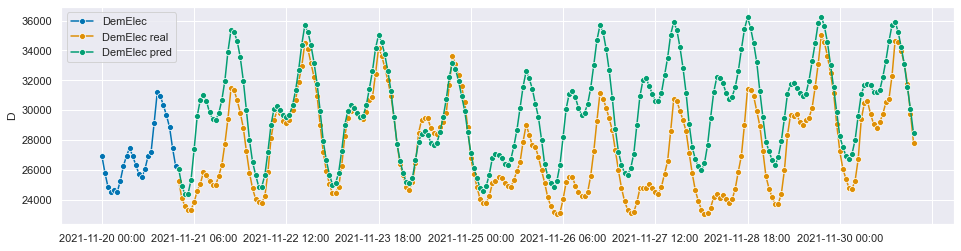

In [65]:
plot_series(y_train_horario[1200:], y_test_horario, pred, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/DEEPAR_datos_horarios.png", dpi=300, bbox_inches='tight')

#### RESIDUOS

In [66]:
residuals_DEEPAR_df = pred[:]
residuals_DEEPAR_df["real_D"] = np.array(y_test_horario)
residuals_DEEPAR_df["residuals"] = residuals_DEEPAR_df["real_D"]-residuals_DEEPAR_df["D"]
residuals_DEEPAR_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_DEEPAR_df

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7750/335045034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_DEEPAR_df["real_D"] = np.array(y_test_horario)
/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7750/335045034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_DEEPAR_df["residuals"] = residuals_DEEPAR_df["real_D"]-residuals_DEEPAR_df["D"]


,predicted_D,real_D,residuals
2021-11-21 01:00,26014.222656,25239.0,-775.222656
2021-11-21 02:00,24929.208984,24075.0,-854.208984
2021-11-21 03:00,24355.378906,23579.0,-776.378906
2021-11-21 04:00,24362.392578,23286.0,-1076.392578
2021-11-21 05:00,25316.087891,23324.0,-1992.087891
...,...,...,...
2021-11-30 20:00,34198.726562,33941.0,-257.726562
2021-11-30 21:00,33061.035156,33098.0,36.964844
2021-11-30 22:00,31560.023438,31768.0,207.976562
2021-11-30 23:00,30037.964844,29751.0,-286.964844


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

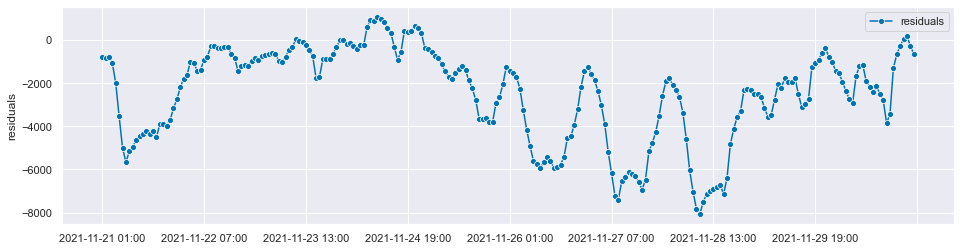

In [67]:
plot_series(residuals_DEEPAR_df["residuals"], labels=["residuals"])

Vemos que los valores obtenidos en los residuos son realmente malos. Veamos qué ocurre con las métricas

#### MÉTRICAS

In [68]:
MAPE_DEEPAR = mean_absolute_percentage_error(y_test_horario, pred)
MAPE_DEEPAR

0.08840902754905292

In [69]:
rmse_DEEPAR = MeanSquaredError(square_root=True)
rmse_DEEPAR = rmse_DEEPAR(y_test_horario, pred)
rmse_DEEPAR

3267.5017250804485

In [70]:
r2_DEEPAR = r2_score(y_test_horario, pred)
r2_DEEPAR

-0.10119099900832418

### RESUMEN MÉTRICAS DE TODOS LOS MODELOS

In [71]:
MAPE = [MAPE_NAIVE, MAPE_ETS, MAPE_ARIMA, MAPE_PROPHET, MAPE_DEEPAR]
RMSE = [rmse_NAIVE, rmse_ETS, rmse_ARIMA, rmse_PROPHET, rmse_DEEPAR]
R2 = [r2_NAIVE, r2_ETS, r2_ARIMA, r2_PROPHET, r2_DEEPAR]
data = {"MAPE": MAPE, "RMSE":RMSE, "R2":R2}
df_metricas = pd.DataFrame(data, columns=["MAPE", "RMSE", "R2"])
df_metricas.index=["Naive", "ETS", "ARIMA", "Prophet", "DEEPAR"]
df_metricas

,MAPE,RMSE,R2
Naive,0.059969,2032.274424,0.574014
ETS,0.068471,2537.392742,0.335941
ARIMA,1.998508,27755.568903,-78.456836
Prophet,0.048707,1865.096023,0.641216
DEEPAR,0.088409,3267.501725,-0.101191


#### RESIDUOS

Primeramente debemos tener los índices de todos los data frames en el mismo formato.

In [72]:
residuals_PROPHET_df["residuals"].index = residuals_ARIMA_df["residuals"].index

Veamos todos los residuos en una sola gráfica

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

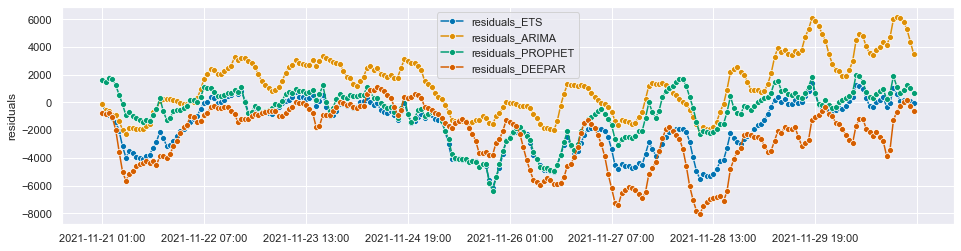

In [73]:
plot_series(residuals_ETS_df["residuals"], residuals_ARIMA_df["residuals"], residuals_PROPHET_df["residuals"], residuals_DEEPAR_df["residuals"], labels=["residuals_ETS", "residuals_ARIMA", "residuals_PROPHET", "residuals_DEEPAR"])

Es difícil sacar conclusiones de este gráfico. Sin embargo, podemos observar que el modelo Prophet es el modelo que más cerca se encuentra en la línea horizontal *residuo=0*. Luego, podemos confirmar lo visto con las métricas. El modelo Prophet es el mejor de los analizados.

## PREDICCIÓN DE LOS PRIMEROS 7 DÍAS DE DICIEMBRE

La predicción de los primeros 7 días de diciembre con periodicidad horaria la haremos con el mejor de los modelos, es decir, con el modelo Prophet. Para ello, lo primero que deberemos hacer será coger todos los datos como datos de training y después predecir en el nuevo horizonte de predicción de 7 días. 7 días en periodicidad horaria implica un total de 7*24=168 datos a predecir.

In [74]:
fh_new = np.arange(1,241)

In [75]:
y = datos_horarios["2021-10":].reset_index(drop=False)
y.columns = ["ds", "y"]
y.tail()

,ds,y
1460,2021-11-30 20:00:00,33941.0
1461,2021-11-30 21:00:00,33098.0
1462,2021-11-30 22:00:00,31768.0
1463,2021-11-30 23:00:00,29751.0
1464,2021-12-01 00:00:00,27799.0


In [76]:
m = Prophet()
m.fit(y)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.9139


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4185.28     0.0037637       133.454      0.3052           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       4194.87   0.000545584       166.255   2.623e-06       0.001      249  LS failed, Hessian reset 
     199       4195.66   0.000608772       209.584      0.3049      0.8062      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       4196.78   0.000646048       166.158   5.802e-06       0.001      398  LS failed, Hessian reset 
     299       4197.45   0.000172769       65.5674           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4199.19    0.00028121       228.116           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha

A continuación calculamos y mostramos la predicción para los primeros 7 días de diciembre.

In [77]:
future_final = m.make_future_dataframe(periods=len(fh_new), freq="H")
forecast_final = m.predict(future_final)

      alpha0  # evals  Notes 
     439       4199.58   0.000119539       168.689   1.523e-06       0.001      659  LS failed, Hessian reset 
     499       4199.82   0.000669201        284.22           1           1      735   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     549        4201.2    0.00024436        260.22   1.464e-06       0.001      835  LS failed, Hessian reset 
     599       4202.52   0.000302907       121.955     0.06162           1      890   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     633       4202.59   2.79604e-05       53.5223    4.03e-07       0.001      975  LS failed, Hessian reset 
     697       4202.98   0.000127086       107.359   2.246e-06       0.001     1088  LS failed, Hessian reset 
     699       4202.99   7.00729e-05        83.762           1           1     1090   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eva

Mostramos a continuación los valores para el intervalo de confianza y el valor de la predicción proporcionado por el modelo Prophet.

In [78]:
forecast_final[1465:][["yhat_upper", "yhat_lower", "yhat"]]

,yhat_upper,yhat_lower,yhat
1465,27042.887294,23649.925869,25191.887972
1466,25983.543675,22432.873622,24188.412249
1467,25222.440333,21880.884555,23474.407564
1468,24955.453629,21580.627602,23266.160337
1469,25507.275430,22118.864351,23768.507208
...,...,...,...
1700,33119.441706,28873.136698,31072.403173
1701,32049.266928,27655.632500,29939.531582
1702,30394.575733,26033.019422,28242.346391
1703,28577.569319,24202.544015,26437.497564


Ponemos en el índice de ambos data frames la fecha para después poder visualizar la fecha en el plot.

In [79]:
y.index = y["ds"]

In [80]:
forecast_final.index = forecast_final["ds"]

Hacemos la gráfica de la predicción:

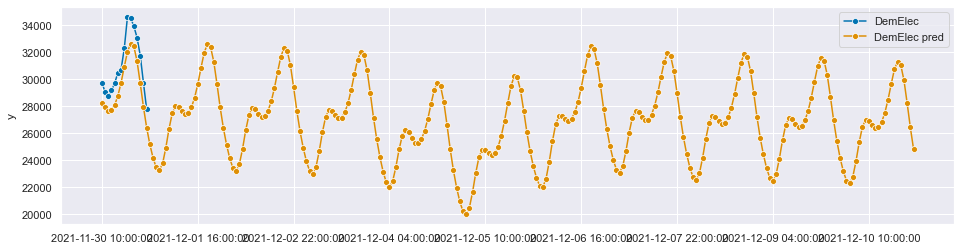

In [81]:
plot_series(y["y"][1450:], forecast_final["yhat"][1450:], labels=["DemElec", "DemElec pred"])
plt.savefig("Images/Prophet_pred_horario.png", dpi=300, bbox_inches='tight')

Además, el modelo Prophet nos muestra un intervalo de confianza para la predicción. Véamoslo.

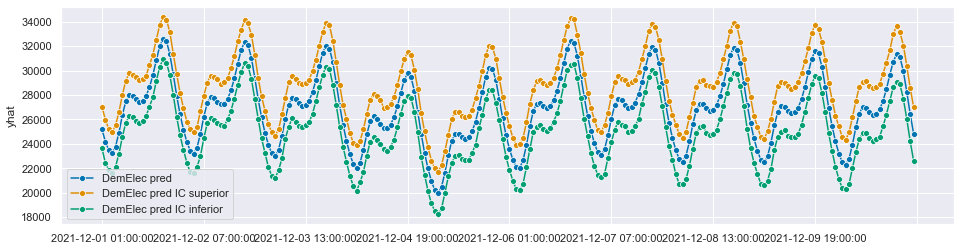

In [82]:
plot_series(forecast_final["yhat"][1465:], forecast_final["yhat_upper"][1465:], forecast_final["yhat_lower"][1465:], labels=["DemElec pred", "DemElec pred IC superior", "DemElec pred IC inferior"])
plt.savefig("Images/Prophet_pred_horario_IC.png", dpi=300, bbox_inches='tight')

Creamos un data frame con la predicción y lo pasamos a csv

In [83]:
prediccion_horarias = pd.DataFrame(forecast_final["yhat"][1465:])
prediccion_horarias["date"] = prediccion_horarias.index
prediccion_horarias

,yhat,date
ds,,
2021-12-01 01:00:00,25191.887972,2021-12-01 01:00:00
2021-12-01 02:00:00,24188.412249,2021-12-01 02:00:00
2021-12-01 03:00:00,23474.407564,2021-12-01 03:00:00
2021-12-01 04:00:00,23266.160337,2021-12-01 04:00:00
2021-12-01 05:00:00,23768.507208,2021-12-01 05:00:00
...,...,...
2021-12-10 20:00:00,31072.403173,2021-12-10 20:00:00
2021-12-10 21:00:00,29939.531582,2021-12-10 21:00:00
2021-12-10 22:00:00,28242.346391,2021-12-10 22:00:00


Eliminamos el índice y nos quedamos únicamente con las 2 columnas para pasar a csv.

In [84]:
prediccion_horarias.to_csv("prediccion_final_horaria", sep=";", index=False)